In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests 
import time

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from geopy.geocoders import Nominatim
import ast

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

# **1. Merge ``df_masters`` & ``df_ratings``**

In [ ]:
# import the dataframes
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (and others) with >= 20 votes, until 2000 aprox

# print information
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_us_new_masters.shape}: df_us_new_masters')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_masters_blended.shape}: df_masters_blended')

(56660, 13): df_uk_masters
(48690, 13): df_us_masters
(63789, 13): df_us_new_masters
(51222, 5): df_ratings_20
(9667, 13): df_masters_blended


<Axes: xlabel='count', ylabel='year'>

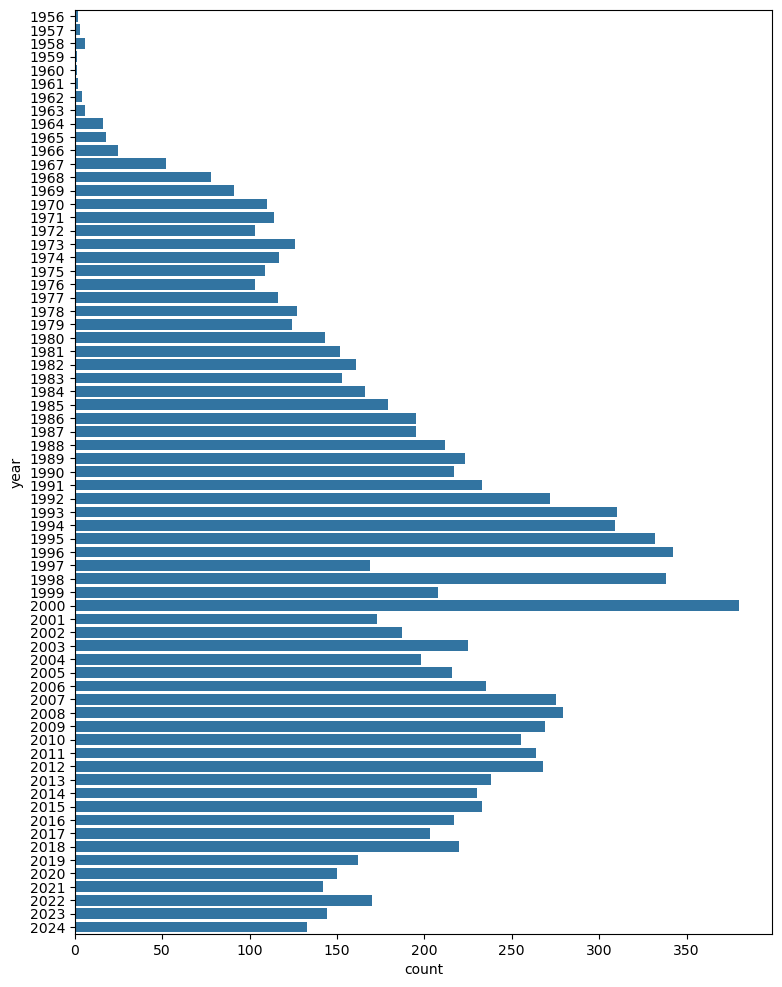

In [66]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters_blended, y='year')

In [3]:
df_uk_masters['master_id'].isna().sum()

0

In [ ]:
df_uk_masters['master_id'].fillna(0, inplace=True)
df_uk_masters['master_id'].isna().sum()

0

## **Concat with the albums previously cleaned**

In [93]:
df_us_2019 = pd.read_csv('Datasets/df_us_2019.csv')
df_us_2019.shape

(200, 13)

In [94]:
df_us_2019['year'].value_counts().head(10)

year
2019    167
2018      6
2012      5
2011      4
2017      3
2009      2
2014      2
2006      1
1990      1
2002      1
Name: count, dtype: int64

In [95]:
df_us_2019['styles'].value_counts().head(10)

styles
['Progressive Metal']                                                                    19
['Metalcore', 'Progressive Metal']                                                        8
['Technical Death Metal', 'Progressive Metal']                                            7
['Prog Rock', 'Progressive Metal']                                                        6
['Space Rock']                                                                            3
['Progressive Metal', 'Prog Rock']                                                        3
['Art Rock', 'Krautrock', 'Psychedelic Rock', 'Prog Rock', 'Space Rock', 'Folk Rock']     3
['Death Metal']                                                                           2
[]                                                                                        2
['Prog Rock']                                                                             2
Name: count, dtype: int64

In [96]:
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_us_new_masters.shape

(18011, 13)

In [98]:
df_concat = pd.concat([df_us_new_masters, df_us_2019])
df_concat.shape

(18211, 13)

In [99]:
check_duplicates(df_concat)

Found 4 duplicates:
Resulting dataset: (18207, 13)


<Axes: xlabel='count', ylabel='year'>

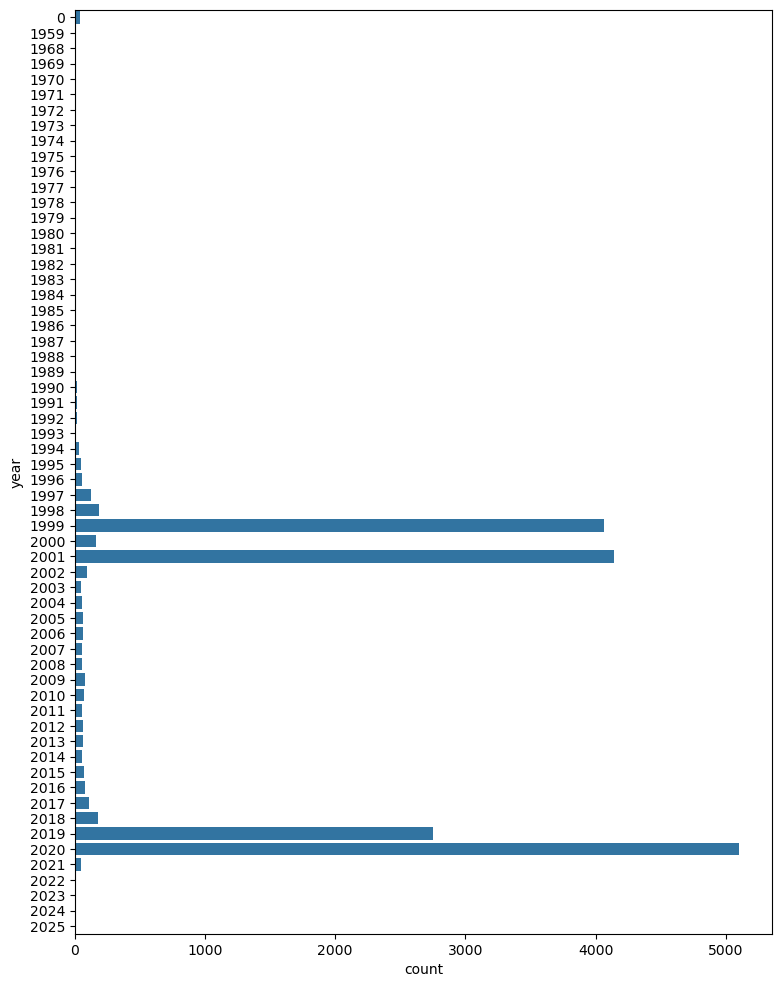

In [100]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,12))
sns.countplot(data=df_concat, y='year')

**Export to csv**

In [101]:
df_concat.to_csv('Datasets/df_us_new_masters.csv', index=False)

In [19]:
df_masters = df_concat

In [3]:
df_masters = df_us_new_masters

## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [59]:
# all the artists in df_masters
df_masters['artist'].nunique()

27045

In [60]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

4816

In [34]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(15584, 13): df_masters
(656, 13): df_masters_parenthesis


In [ ]:
df_ratings_10['artist'].nunique()

23683

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_10_parenthesis = df_ratings_10[df_ratings_10['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_10_parenthesis['artist'].nunique()

0

In [ ]:
# print information
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_ratings_10_parenthesis.shape}: df_ratings_10_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [ ]:
df_ratings_10_parenthesis.sample(5)

,album_id,artist,title,rating,votes
66859,299052,Vacations (AUS),Vibes and Days,3.87,15
66521,293448,Carnation (BE),Chapel of Abhorrence,3.35,40
34007,67551,Soundtrack (Video Game),The Legend of Zelda: Twilight Princess OST,4.23,80
39072,84542,Doom (JPN),Complicated Mind,4.16,25
36362,74638,Tempest (Can),Passages,3.73,37


In most of the artists, the information between parenthesis is the country of origin

In [39]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

2364       100% Proof
3971       100% Proof
2622     20/20 Vision
1164       38 Special
2445       38 Special
            ...      
3727              XIT
3045            Ya Ya
1735    Youth In Asia
3931              ZED
599              Zeno
Name: artist, Length: 656, dtype: object

In [ ]:
# delete these characters
df_ratings_10_parenthesis_clean = df_ratings_10_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_10_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [ ]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_10_parenthesis_clean, on='artist')

,artist
0,Alaska
1,Alaska
2,Alaska
3,Alaska
4,Attila
...,...
123,X
124,X
125,X
126,X


In [45]:
df_masters[df_masters['artist'].str.contains('Alaska ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1516,594810.0,309057.0,2702245,US,Alaska (8),The Pack,1985,42.32,9,"['LP', 'Album', 'Stereo']",['Rock'],['Hard Rock'],Alaska was a British hard rock band led by Ber...
2990,594810.0,591189.0,1175493,UK,Alaska (8),Heart Of The Storm,1984,0.00,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'AOR']",Alaska was a British hard rock band led by Ber...


In [ ]:
df_ratings_10[df_ratings_10['artist'].str.contains('Alaska ')]

,album_id,artist,title,rating,votes
48864,135438,Alaska (USA),Everything is Fine,3.38,12
57915,203926,Alaska (USA),Shrine,3.54,12


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [4]:
df_masters.shape

(37597, 13)

In [5]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_masters['artist'].nunique()} unique artists in df_masters")

28995 unique artists in df_masters


In [6]:
df_ratings_20['artist'] = df_ratings_20['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_ratings_20['artist'].nunique()} unique artists in df_ratings_20")

14837 unique artists in df_ratings_20


## **&/and Cleaning**

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [7]:
df_ratings_20[df_ratings_20['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
34041,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
35157,150508,Ultimate Spinach,Behold and See,3.89,23


In [8]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [9]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings_20[['artist', 'title']] = df_ratings_20[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [10]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


## Actual merge

In [4]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(4970, 16)

In [12]:
df[df['artist']=='Bob Dylan and The Band']

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile


In [13]:
df.sample(5)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
1830,26740,Blood Has Been Shed,Novella Of Uriel,3.52,43,299862.0,2201131,19394530,US,2001,0.00,11,['Album'],['Rock'],['Metalcore'],"Metalcore band from the state of Connecticut, ..."
1912,30239,Lights Out Asia,Eyes Like Brontide,3.94,235,550749.0,436530,1410106,US,2008,52.35,8,['Album'],"['Electronic', 'Rock']","['Leftfield', 'IDM', 'Post Rock', 'Ambient']",Mike Ystad : Electronics\r\nChris Schafer: Gui...
2630,224881,The World Is Quiet Here,Prologue,4.11,27,7370026.0,1606044,14131251,US,2018,51.55,8,"['MP3', 'Album', 'Stereo']",['Rock'],['Progressive Metal'],"A 5 piece metal band based out of Oshkosh, Wis..."
911,8490,Earshot,Two,3.27,115,269067.0,553735,764269,USA & Canada,2004,42.45,11,['Album'],['Rock'],"['Alternative Rock', 'Hard Rock']",Alternative Rock (Modern Rock) band from Los A...
617,5133,Melt-Banana,Cell-Scape,3.88,361,190371.0,43911,527304,US,2003,0.00,10,"['LP', 'Album']",['Rock'],"['Punk', 'Hardcore', 'Noise Rock']","Melt-Banana is a band from Tokyo, Japan. They ..."


In [14]:
df['release_country'].value_counts().head(10)

release_country
US              2314
Europe           318
Germany          186
UK                38
Sweden            38
USA & Canada      36
France            29
Canada            29
Australia         28
Netherlands       27
Name: count, dtype: int64

In [15]:
print(f"{round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have more than 20 votes")

8.69 % of the albums have more than 20 votes


### First inspection

**Change the dtype of ``artist_id``**

In [19]:
df[df['artist_id'].isna()]

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile


In [17]:
df[df['artist']=='Meshuggah'].sample(3)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
2465,96456,Meshuggah,Koloss,3.75,1940,252273.0,421823,3498596,Germany,2012,54.78,10,['Album'],['Rock'],"['Thrash', 'Death Metal', 'Progressive Metal',...","Swedish progressive metal band from Umeå, whic..."
61,457,Meshuggah,Nothing,3.99,1754,252273.0,14397,386915,Germany,2002,53.07,10,"['Album', 'Enhanced']",['Rock'],"['Thrash', 'Experimental']","Swedish progressive metal band from Umeå, whic..."
62,457,Meshuggah,Nothing,3.99,1754,NaN,0,2223511,US,2002,53.10,10,"['Album', 'Enhanced']",['Rock'],"['Thrash', 'Experimental']",NaN


In [18]:
df.loc[62, 'artist_id'] = 252273

In [20]:
df['artist_id'] = df['artist_id'].astype(int)
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,53,Dream Theater,Train of Thought,3.87,2670,260935,52100,432029,US,2003,69.35,7,"['Album', 'Enhanced']",['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos..."


**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [21]:
df = columns_show_ratings(df)
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,53,Dream Theater,Train of Thought,2003,3.87,2670,69.35,7,US,"['Album', 'Enhanced']",['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos...",260935,52100,432029


**I keep only rock albums**

In [22]:
# how many of them are Rock albums?
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['genres'].str.contains('Rock')]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3269


**Drop compilations**

In [23]:
df['release_type'].isna().sum()

0

In [24]:
df['release_type'].value_counts().head(10)

release_type
['Album']                             2031
['LP', 'Album']                        312
['Album', 'Enhanced']                  152
['LP', 'Album', 'Limited Edition']     102
['Album', 'Stereo']                     93
['Album', 'Limited Edition']            54
['LP', 'Album', 'Stereo']               41
['FLAC', 'Album']                       40
['MP3', 'Album']                        29
['LP']                                  27
Name: count, dtype: int64

In [25]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [65]:
df.loc[1230, 'release_type']

"['Album']"

In [73]:
df.loc[1229, 'release_type'] = 'Album'
df.loc[8799, 'release_type'] = 'Album'

In [74]:
df['release_type'].isna().sum()

0

In [26]:
print(df['release_type'].dtype)

object


In [27]:
type(df.release_type[0])

str

In [28]:
print(f'There are {df[df['release_type'].str.contains('Compilation')].shape[0]} compilations')

There are 0 compilations


In [29]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['release_type'].str.contains('Compilation')]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3269


In [30]:
# number of unique artists
df['artist'].nunique()

2204

**YOB** té **8** albums a Sputnik (``df_ratings_20``), però nomes **2** a Discogs de UK, tot i que és una banda de UK. 

Si apareixen al df de US, hauré de fer un concat/merge

In [31]:
df[df['artist']=='YOB']

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
479,3646,YOB,The Illusion Of Motion,2004,3.94,183,56.37,4,Germany,['Album'],['Rock'],"['Stoner Rock', 'Doom Metal']",Yob is an American stoner/doom metal band from...,563922,129478,1119948
1878,29146,YOB,The Unreal Never Lived,2005,4.06,225,51.80,4,US,['Album'],['Rock'],['Doom Metal'],Yob is an American stoner/doom metal band from...,563922,129479,732137
2328,60240,YOB,Elaborations Of Carbon,2002,3.42,73,70.12,6,US,['Album'],['Rock'],['Doom Metal'],Yob is an American stoner/doom metal band from...,563922,577362,1593094
2696,282109,YOB,Our Raw Heart,2018,3.87,295,73.27,7,US,"['FLAC', 'Album']",['Rock'],"['Doom Metal', 'Sludge Metal']",Yob is an American stoner/doom metal band from...,563922,1374548,13688747


In [32]:
df_ratings_20[df_ratings_20['artist']=='YOB']

,album_id,artist,title,rating,votes
2483,3646,YOB,The Illusion Of Motion,3.94,183
15489,29146,YOB,The Unreal Never Lived,4.06,225
19314,39606,YOB,The Great Cessation,3.90,205
24379,60240,YOB,Elaborations Of Carbon,3.42,73
24380,60241,YOB,Catharsis,3.99,140
28069,80046,YOB,Atma,3.78,259
36250,163668,YOB,Clearing The Path To Ascend,3.92,331
43343,282109,YOB,Our Raw Heart,3.87,295


## **``df`` real cleaning**

I want to **drop duplicates** and releases from **bands outside of the UK and the US**, I only want to keep brittish and american artists. Also **drop compilations and live albums**.

### **Drop duplicates**

**``master_id = 0``**

In [33]:
df.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks']].duplicated().sum()

5

In [34]:
# these albums are the same, except one entry has master_id=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3264


**``album_length = 0``**

In [35]:
df.sort_values('album_length', inplace=True, ascending=False) # so I keep the album_length=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated().sum()

12

In [36]:
df[df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated()]['album_length'].value_counts()

album_length
0.00     6
56.28    1
53.07    1
45.42    1
41.35    1
36.30    1
13.27    1
Name: count, dtype: int64

In [37]:
# most of these albums are the same, except one entry has album_length=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3264
Rows after dropping: 3252


**duplicates by ``artist`` and ``title``**

In [38]:
df[df[['artist', 'title']].duplicated()].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
464,15873,Days of the New,Days of the New,2001,3.70,157,56.92,13,US,['Album'],['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Days of the New is an American rock band from ...,85890,659503,1291898
1147,193607,Cattle Decapitation,The Anthropocene Extinction,2020,3.91,777,46.23,12,US,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Death Metal', 'Grindcore']",American grindcore/death metal band based in S...,388407,0,15816188
1275,102755,The Contortionist,Intrinsic,2020,3.38,1024,45.12,11,US,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Progressive Metal', 'Death Metal', 'Math Rock']",The Contortionist is an American progressive m...,1964016,0,17467792
1432,11604,Black Label Society,Shot to Hell,2020,2.98,261,43.67,13,US,"['LP', 'Album']",['Rock'],['Heavy Metal'],American heavy metal band formed in 1998 in Lo...,299863,0,31008001
1497,13296,Nonpoint,Development,0,3.27,113,42.92,12,US,"['Album', 'Reissue']","['Hip Hop', 'Rock']",['Nu Metal'],Nonpoint is an American heavy metal band from ...,264928,534163,1407838


In [39]:
df[['artist', 'title']].duplicated().sum()

20

In [40]:
df[df['title']=='Days of the New	'.strip()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
296,15873,Days of the New,Days of the New,1999,3.7,157,62.25,14,US,['Album'],['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Days of the New is an American rock band from ...,85890,447101,435592
464,15873,Days of the New,Days of the New,2001,3.7,157,56.92,13,US,['Album'],['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Days of the New is an American rock band from ...,85890,659503,1291898


**Drop incorrect albums**

In [474]:
# check one by one if necessary
try:
    df.drop([12027], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(12004, 16)


**Change specific values that are wrong/missing**

In [454]:
# change specific values that are wrong/missing

# df.loc[9591, 'title'] = 'Santana III'
# df.loc[9591, 'rating'] = 4.26
# df.loc[9591, 'votes'] = 227
df.loc[4695, 'album_length'] = 30.25
# df.loc[3286, 'tracks'] = 15
# df.loc[9575, 'year'] = 1996

In [404]:
# calculate the decimals of the album length (seconds)
29/60

0.48333333333333334

**``df_ratings_top``**

If there are two albums with the same name, but one is for instance an EP or a compilation I don't want to keep, I have to drop it from df,

but also from ``df_ratings_top``, otherwise I will keep running into this duplicated album every time I add more albums

In [462]:
df_ratings_20[df_ratings_20['artist']=='Pepper'.strip()]

,album_id,artist,title,rating,votes
2436,3581,Pepper,Kona Town,3.87,114
2708,3970,Pepper,In With The Old,3.46,61
8649,14537,Pepper,No Shame,3.34,79
15291,28637,Pepper,Pink Crustaceans and Good Vibrations,3.26,40
16813,32335,Pepper,Give'n It,3.22,20
33650,130639,Pepper,Pepper,2.52,21


In [419]:
# check one by one if necessary
try:
    df_ratings_20.drop([4051], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51240, 5)


In [477]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **Drop live albums**

**Hauré d'eliminar tmb albums de 'MTV Unplugged'**

Let's try to detect the live albums by the title

#### **'Live at'**

In [41]:
df.shape

(3252, 16)

In [42]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 9 albums with 'Live at ' in the title


In [43]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
4,2155,Coheed and Cambria,Live at the Starland Ballroom,2005,4.19,264,205.03,36,US,"['NTSC', 'Album']",['Rock'],"['Alternative Rock', 'Emo', 'Prog Rock']",A progressive rock band based out of Nyack and...,256629,819727,6761981
8,998,Dream Theater,Live at Budokan,2004,4.12,366,165.35,18,US,['Album'],['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos...",260935,52737,835823
41,1532,Jimi Hendrix,Live at Woodstock,1999,4.40,195,96.50,16,Europe,"['Album', 'Remastered']",['Rock'],['Psychedelic Rock'],American modern electric blues guitar virtuoso...,110593,251465,1035861
127,18329,Rage Against the Machine,Live at the Grand Olympic Auditorium,2003,3.77,272,71.02,16,US,['Album'],"['Hip Hop', 'Rock', 'Funk / Soul']","['Hard Rock', 'Alternative Rock', 'Hardcore', ...",Alternative / funk / modern rock band formed i...,12212,92111,368202
190,94660,Neil Young,Live at Massey Hall 1971,2007,4.43,147,67.52,17,US,"['HDCD', 'Album', 'Stereo']",['Rock'],"['Country Rock', 'Southern Rock', 'Acoustic']",Neil Young is a Canadian-American singer-songw...,138556,38727,2305420
191,73273,The Jimi Hendrix Experience,Live At Berkeley,2003,4.25,26,67.47,12,US,['Album'],['Rock'],"['Psychedelic Rock', 'Classic Rock']",The Jimi Hendrix Experience (often shortened t...,255672,82849,1335394
275,8991,Eels,Eels With Strings - Live At Town Hall,2006,3.90,40,63.08,22,Europe,['Album'],['Rock'],['Indie Rock'],US alternative rock band formed in 1995 by sin...,74395,117733,630958
2552,1618,Incubus,Alive at Red Rocks,2004,4.23,224,21.95,24,US,"['DVD-Video', 'Multichannel', 'NTSC', 'Album']",['Rock'],"['Alternative Rock', 'Funk Metal']",Alternative Rock band (formerly Funk Metal & N...,149192,59255,9364072
3210,6864,Clutch,Live At The Googolplex,2003,3.52,25,0.00,15,US,['LP'],['Rock'],['Stoner Rock'],Clutch is an American Rock band that started d...,289116,184641,5418192


In [44]:
# correct, they are all live albums
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains('Live at ', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3252
Rows after dropping: 3243


#### **'Live in'**

In [45]:
print(f"There are {df[df['title'].str.contains(r'^Live in ', case=False)].shape[0]} albums with 'Live in ' in the title")

There are 6 albums with 'Live in ' in the title


In [46]:
# Let's check them before deleting them
df[df['title'].str.contains(r'^Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
29,2447,Linkin Park,Live In Texas,2003,3.23,489,108.68,29,Europe,"['Album', 'Enhanced']",['Rock'],['Nu Metal'],"Alternative rock band from Agoura Hills, Calif...",40029,74531,383474
185,655,Strung Out,Live in a Dive,2003,4.38,53,68.07,21,US,['Album'],['Rock'],['Punk'],"American punk rock band from Simi Valley, Cali...",253310,287638,1146384
212,50617,Testament,Live in London,2005,4.29,49,66.12,14,US,['Album'],['Rock'],['Thrash'],Thrash Metal (Heavy Metal) band from San Franc...,137126,281150,896926
2788,375463,King Gizzard and The Lizard Wizard,Live In San Francisco '16,2020,4.19,26,0.00,13,Australia,"['LP', 'Limited Edition']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria...",2532180,1841534,16522995
2864,11810,Lagwagon,Live In A Dive,2005,4.05,53,0.00,22,US,['LP'],['Rock'],['Punk'],American punk rock band originally named [a=Se...,253308,246514,1485031
2947,24160,Joan of Arc,"Live In Chicago, 1999",1999,3.59,23,0.00,13,US,['LP'],['Rock'],"['Post Rock', 'Indie Rock']","Chicago, IL-based indie/experimental outfit. ...",279142,148862,740028


In [49]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'^...Live in ', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3243
Rows after dropping: 3235


In [50]:
# This is a studio album
df[df['title'].str.contains('Live in ', case=True)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


#### **'MTV Unplugged'**

In [51]:
print(f"There are {df[df['title'].str.contains(r'MTV Unplugged', case=False)].shape[0]} albums with 'MTV Unplugged' in the title")

There are 0 albums with 'MTV Unplugged' in the title


In [52]:
# Let's check them before deleting them
df[df['title'].str.contains(r'MTV Unplugged', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [53]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'MTV Unplugged', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3235
Rows after dropping: 3235


### **Drop compilations sorting albums by the top rated**

#### **'Greatest Hits'**

In [54]:
print(f"There are {df[df['title'].str.contains(r'Greatest Hits', case=False)].shape[0]} albums with 'Greatest Hits' in the title")

There are 1 albums with 'Greatest Hits' in the title


In [55]:
# Let's check them before deleting them
df[df['title'].str.contains(r'Greatest Hits', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
1759,56010,Alien Ant Farm,Greatest Hits,1999,3.22,37,40.32,10,US,['Album'],['Rock'],"['Alternative Rock', 'Garage Rock', 'Hard Rock...",American alternative rock / modern rock band t...,152509,581207,3402074


In [56]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'Greatest Hits', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3235
Rows after dropping: 3234


#### **Sorting by the top rated and most rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [57]:
start_row = 50

df.sort_values(['rating', 'votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
470,16873,Disillusion,Back to Times of Splendor,2004,4.26,611,56.83,6,US,['Album'],['Rock'],"['Progressive Metal', 'Power Metal', 'Melodic ...",Melodic progressive death metal outfit from Le...,388646,413839,6499044
154,125094,Gustavo Cerati,Bocanada,1999,4.26,90,69.35,15,Argentina,['Album'],"['Electronic', 'Rock', 'Pop']","['Alternative Rock', 'Art Rock', 'Dream Pop', ...","Born: August 11, 1959, Buenos Aires, Argentina...",170488,917996,10402046
1769,17023,Os Mutantes,A Divina Comédia ou Ando Meio Desligado,1970,4.25,61,40.23,11,Brazil,"['LP', 'Album', 'Mono']","['Rock', 'Latin']","['Psychedelic Rock', 'MPB']",Pop trio from Brazil. \r\n\r\nFormed in the la...,15161,54517,2823527
755,845,Wilco,Yankee Hotel Foxtrot,2002,4.24,1675,51.57,11,Europe,"['LP', 'Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Country Rock']",American alternative rock band formed in 1994 ...,102984,10363,4426525
78,18071,Weakling,Dead as Dreams,2000,4.24,537,76.15,5,US,['Album'],['Rock'],['Black Metal'],"American black metal band from San Francisco, ...",251627,196126,9926322
3076,2350,The Weakerthans,Reconstruction Site,2003,4.24,521,0.00,14,USA & Canada,"['LP', 'Album']",['Rock'],"['Emo', 'Punk']","Punk influenced band from Winnipeg, Canada, fo...",283746,204263,2030928
56,18044,The Arrogant Sons of Bitches,Three Cheers For Disappointment,2006,4.24,485,79.28,44,US,"['Enhanced', 'Album']",['Rock'],"['Ska', 'Punk']",The Arrogant Sons of Bitches (commonly abbrevi...,1690973,401846,3349754
3165,22185,Trespassers William,Different Stars,2002,4.24,299,0.00,11,US,['Album'],['Rock'],"['Folk Rock', 'Lo-Fi', 'Ethereal']","Line-ups :\r\n1999-2001 : Anna-Lynne Williams,...",283740,127194,516231
3096,3146,Blind Guardian,Live,2003,4.24,143,0.00,27,NaN,"['LP', 'Album', 'Picture Disc']",['Rock'],['Heavy Metal'],"Power/heavy metal band from Krefeld, Nordrhein...",262577,198529,2592998
139,6394,Drive-By Truckers,The Dirty South,2004,4.24,114,70.33,14,US,"['Album', 'Stereo']",['Rock'],['Southern Rock'],Alternative country/Southern rock band based i...,493270,188892,1094881


In [560]:
# check one by one if necessary
try:
    df.drop([3433], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11952, 16)


**drop albums also from ``df_ratings_top``** if they are live albums, compilations, bands from outside the UK or US...

In [758]:
df_ratings_20[df_ratings_20['artist']=="Ulver".strip()]

,album_id,artist,title,rating,votes


In [611]:
# check one by one if necessary
try:
    df_ratings_20.drop([7066], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51221, 5)


**Drop one artist**

In [765]:
print(f"Rows before dropping: {df_ratings_20.shape[0]}")
df_ratings_20 = df_ratings_20[df_ratings_20['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df_ratings_20.shape[0]}")

Rows before dropping: 51158
Rows after dropping: 51144


**export again to .csv**

In [566]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **``year = 0``**

In [58]:
df[df['year']==0].shape

(12, 16)

In [767]:
df[df['year']==0].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
11753,6042,Death Cab for Cutie,Something About Airplanes,0,3.52,440,43.3,10,US,"['Album', 'Reissue']",['Rock'],['Indie Rock'],"American indie rock band formed in Bellingham,...",280098,3443,409339


In [768]:
df.loc[11753, 'year'] = 1998

In [733]:
# check one by one if necessary
try:
    df.drop([9935], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11941, 16)


**Drop one artist**

In [764]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 11922
Rows after dropping: 11920


### **Drop ratings and sort columns**

In [59]:
df = columns_hide_ratings(df)

In [60]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,514808.0,3666645,3503643,US,Black 47,Live In New York City,1999,67.2,12,['Album'],['Rock'],['Alternative Rock'],Black 47 was an American Celtic rock band from...


In [61]:
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,255680,267825,1911585,Europe,Eagles,Eagles,2005,325.5,84,['Album'],['Rock'],"['Country Rock', 'Classic Rock']",American rock band founded in 1971 by [a=Glenn...


In [62]:
df['artist'].nunique()

2202

In [63]:
df['artist_id'] = df['artist_id'].astype(int)

### **Export to csv**

In [5]:
df.to_csv('Datasets/df_us_new_masters_clean.csv', index=False)

<Axes: xlabel='count', ylabel='year'>

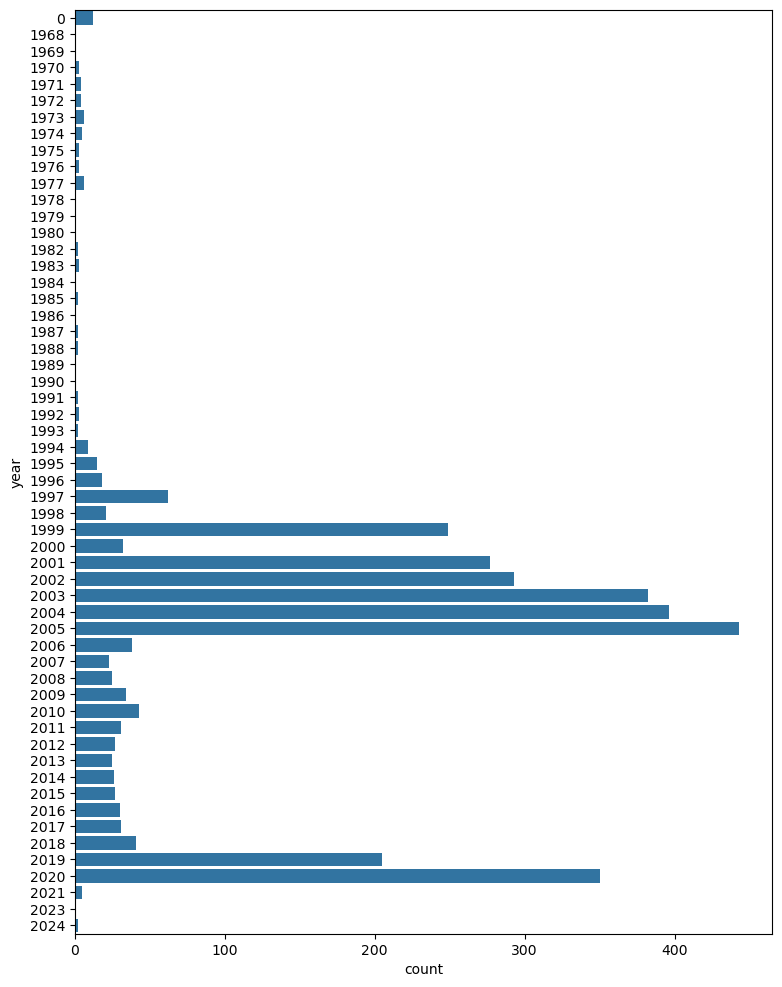

In [65]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')

# **Statistics**

In [3]:
# import the df
df = pd.read_csv('Datasets/df_rock_ratings.csv')
df.shape 

(12059, 10)

In [10]:
df.artist.nunique()

5095

In [4]:
# average number of votes
np.mean(df['votes'])

199.27423501119495

<Axes: xlabel='rating', ylabel='Count'>

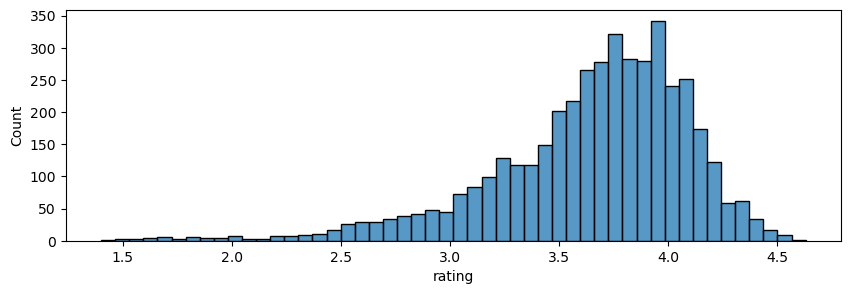

In [5]:
plt.figure(figsize=(10,3))
sns.histplot(data=df[df['votes']>100], x='rating')

<Axes: xlabel='votes', ylabel='Count'>

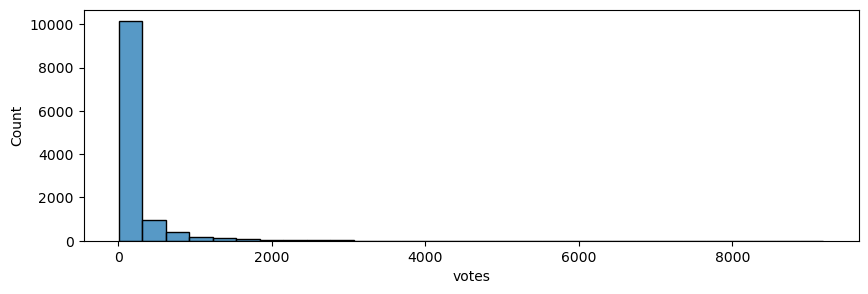

In [6]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, x='votes', bins=30)

In [17]:
df[df['votes']>=20].shape

(9380, 10)

In [20]:
df[df['votes']>=20].artist.nunique()

3823

In [44]:
votes = 20

print(f"{df[df['votes']>=votes].shape[0]} of {df.shape[0]} albums have more than {votes} votes")
print(f"This represents {round(df[df['votes']>=votes].shape[0] / df.shape[0] *100, 2)} % of the albums")

9380 of 12059 albums have more than 20 votes
This represents 77.78 % of the albums


In [45]:
df_rock_ratings_20 = df[df['votes']>=20]
df_rock_ratings_20.shape

(9380, 10)

In [46]:
df_rock_ratings_20.head()

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
0,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']",US,"El Paso, Texas based band. Formed in 2001 afte..."
1,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock'],Europe,"Muse are an English rock band from Teignmouth,..."
2,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']",UK,"Muse are an English rock band from Teignmouth,..."
3,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']",US,"Finch is a post-hardcore band from Temecula, C..."
4,2002,Transplants,Transplants,3.35,198,45.23,12,['Punk'],US,"Punk rock/rap rock band Los Angeles, CA, Unite..."


In [47]:
df_rock_ratings_20.to_csv('Datasets/df_rock_ratings_20.csv', index=False)